# 00_dataset_intro.ipynb

Here, we inspect the different datasets that we will be using in this project:

* ICESat-2 ATL06 elevation points
    * Processed with [SlideRule](https://slideruleearth.io/)
    * The ATL06 product contains elevation data from ICESat-2, which is a satellite mission using a photon-counting laser altimeter to measure Earth's surface. By sending laser pulses and counting the returned photons, ICESat-2 provides highly accurate measurements of elevation, including ice surface topography, vegetation height, and land features. The ATL06 product specifically focuses on surface elevation and is commonly used as reference for elevation data.
        * SlideRule is able to provide us with reference elevation data from other sources, such as more-accurate Digital Elevation Models (DEMs) so we can quickly check the accuracy of the ATL06 measurements, but more on this later...
    * Shean, David, et al. "SlideRule: Enabling rapid, scalable, open science for the NASA ICESat-2 mission and beyond." Journal of Open Source Software 8.81 (2023): 4982.
* NLCD 
    * National Land Cover Database
    * "Nationwide data on land cover and land cover change 
    at a 30m resolution. The dataset includes various layers such as land cover classification, 
    impervious surfaces, and urban intensity" (credit to Eric gagliano's [EasySnowData](https://github.com/egagli/easysnowdata/blob/6796d17caa01ec45ed086ff1b8fee27feb3e4d1a/easysnowdata/remote_sensing.py#L588)). We're mainly focused on the different vegetation types.
    * Dewitz, J., 2023, National Land Cover Database (NLCD) 2021 Products: U.S. Geological Survey data release, doi:10.5066/P9JZ7AO3

These datasets will be inspected over sites in the conitguous U.S. (CONUS) determined by the NASA Surface Terrain and Vegetation Incubation Program Precursor Coincident Datasets effort (data located at data/wesm_pcd_4way_14-pad_25km2-area.geojson). Read more about this effort [here]((https://science.nasa.gov/earth-science/decadal-surveys/decadal-stv/coincident-datasets/)), and the accompanying, newest, sexiest Python library [coincident](https://coincident.readthedocs.io/en/latest/)

In [15]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import sliderule
from sliderule import icesat2, earthdata
import contextily as ctx
import matplotlib as mpl
import easysnowdata as esd
from tqdm import tqdm
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [19]:
# sites of interest from NASA STV PCD efforts
# no need to get into all of the metadata but that's available at data/PCD_3dep_sites_feb_2025.xml
cols = ['3dep_workunit', '3dep_workunit_id', '3dep_start_datetime', 
        '3dep_end_datetime', '3dep_duration', 'fourway_overlap_area_km2',
        'geometry']
gf_sites_4326 = gpd.read_file("../data/PCD_3dep_sites_feb_2025.geojson")[cols]

##### Here, we have our list of sites where we hope to pull in our ICESat-2 and NLCD data. These sites are aerial LiDAR missions flown by the USGS 3D Elevation Program (3DEP). We care about these missions because they serve as the 'gold standard' for large-scale elevation models and thus serve as a 'ground truth' comparison for our ICESat-2 measurements. We have multiple sites because we want to gather a diverse sample of elevation measurements over various land cover and terrain types. 

##### This list was compiled to not just compare 3DEP to ICESat-2, but also to stereo photogrammetry derived DEMs, NASA's Global Ecosystem Dynamics Investigation (GEDI) elevation data, and other sources. The end goal is to use this list to process our own DEMs from these 3DEP data, but for now we are just going to use the 3DEP vendor provided DEMs for comparison courtesy of SlideRule.

Read more about 3DEP here: https://www.usgs.gov/3d-elevation-program

| Column                    | Description                                              | Data Type            |
|---------------------------|----------------------------------------------------------|----------------------|
| `3dep_workunit`                | Name of the workunit from USGS 3DEP sites                | `string`             |
| `3dep_workunit_id`             | Unique identifier for the workunit                       | `int64`              |
| `3dep_start_datetimne`           | Start date of the data collection (in YYYY-MM-DD format) | `datetime64[ns]`     |
| `3dep_end_datetime`             | End date of the data collection (in YYYY-MM-DD format)   | `datetime64[ns]`     |
| `3dep_duration`   | Duration of data collection in days                      | `float64`            |
| `fourway_overlap_area_km2`   | Area of the 4-way overlap area. Note that this is calculated differently than the geometry.area(), see metadata          | `float64`            |
| `geometry`                | Bbox of the 4-way overlap area (more on "4-way overlap area" in STV PCD readings)             | `shapely.geometry`   |

In [ ]:
print(f"CRS: {gf_sites_4326.crs}, Shape: {gf_sites_4326.shape}")
gf_sites_4326.head(1)

CRS: EPSG:4326, Shape: (37, 1)


,geometry
0,"POLYGON ((-97.07154 40.0004, -96.81786 40.0004..."


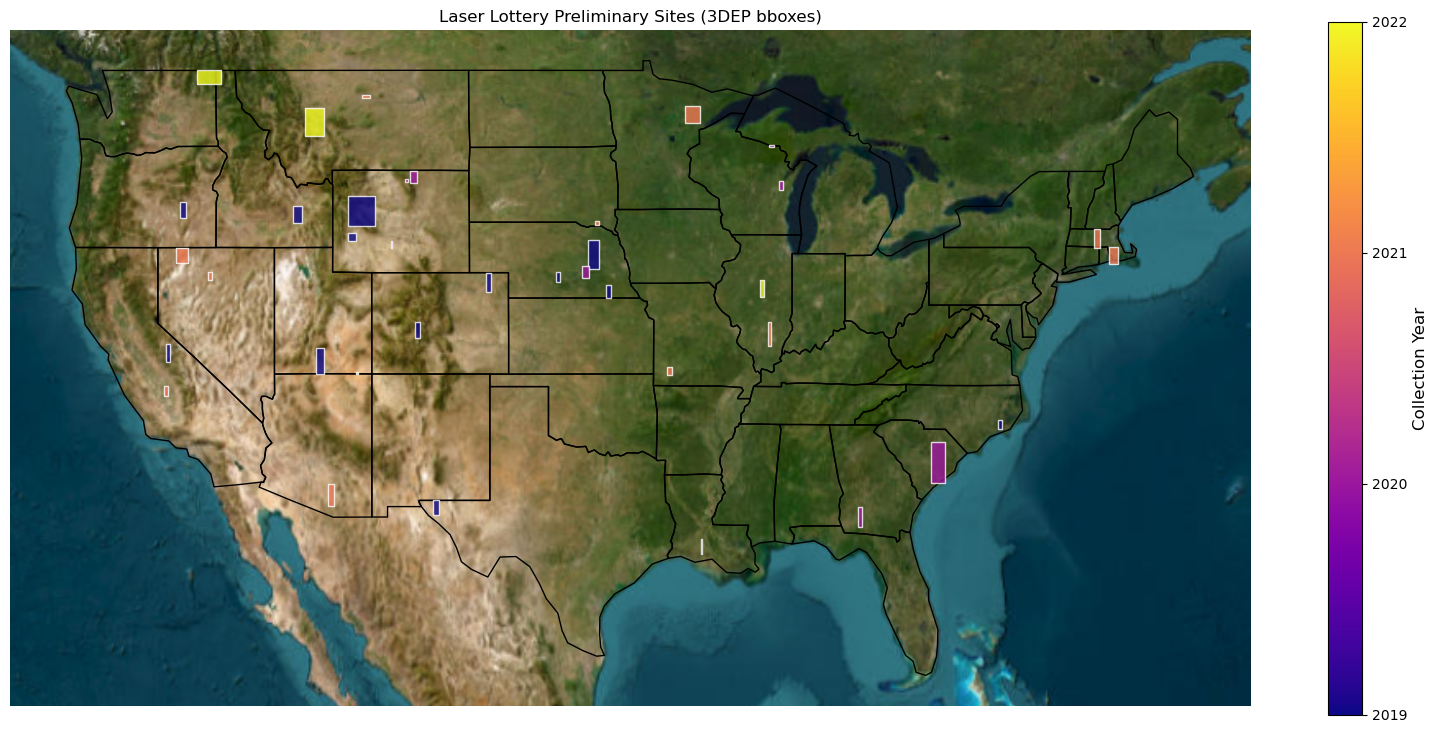

In [ ]:
conus_fn = "https://raw.githubusercontent.com/ResidentMario/geoplot-data/refs/heads/master/contiguous-usa.geojson"
gf_conus = gpd.read_file(conus_fn)
gf_sites_4326["collect_start_year"] = gf_sites_4326["3dep_start_datetime"].dt.year
f, ax = plt.subplots(figsize=(20,9))
gf_conus.plot(ax=ax, facecolor="none", edgecolor="black")
plot = gf_sites_4326.plot(ax=ax, column="collect_start_year", edgecolor="white", alpha=0.8, 
                     cmap="plasma", legend=False)
ctx.add_basemap(ax, crs=gf_conus.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)
ax.set_axis_off()
sm = plt.cm.ScalarMappable(cmap="plasma", 
                           norm=mpl.colors.Normalize(vmin=gf_sites_4326["collect_start_year"].min(), 
                                                     vmax=gf_sites_4326["collect_start_year"].max()))
sm.set_array([])
cbar = f.colorbar(sm, ax=ax)
cbar.set_ticks([2019, 2020, 2021, 2022])
cbar.set_ticklabels([2019, 2020, 2021, 2022])
cbar.set_label('Collection Year', fontsize=12)
ax.set_title("Laser Lottery Preliminary Sites (3DEP bboxes)");

### NLCD

Yeah we're doing NLCD first even though I listed it second at the top of the notebook. We gotta see the land cover distribution of our sites before we move forward with data processing.

Credit to Eric gagliano's [EasySnowData](https://github.com/egagli/easysnowdata/blob/6796d17caa01ec45ed086ff1b8fee27feb3e4d1a/easysnowdata/remote_sensing.py#L588) for making this super easy 😍

Let's look at what one of these rasters looks like

In [ ]:
# let's just pull in data for one of our sites as an example before we expand
gf_search = gf_sites_4326.iloc[[0]]

In [ ]:
nlcd_landcover_da = esd.remote_sensing.get_nlcd_landcover(gf_search, layer='landcover')

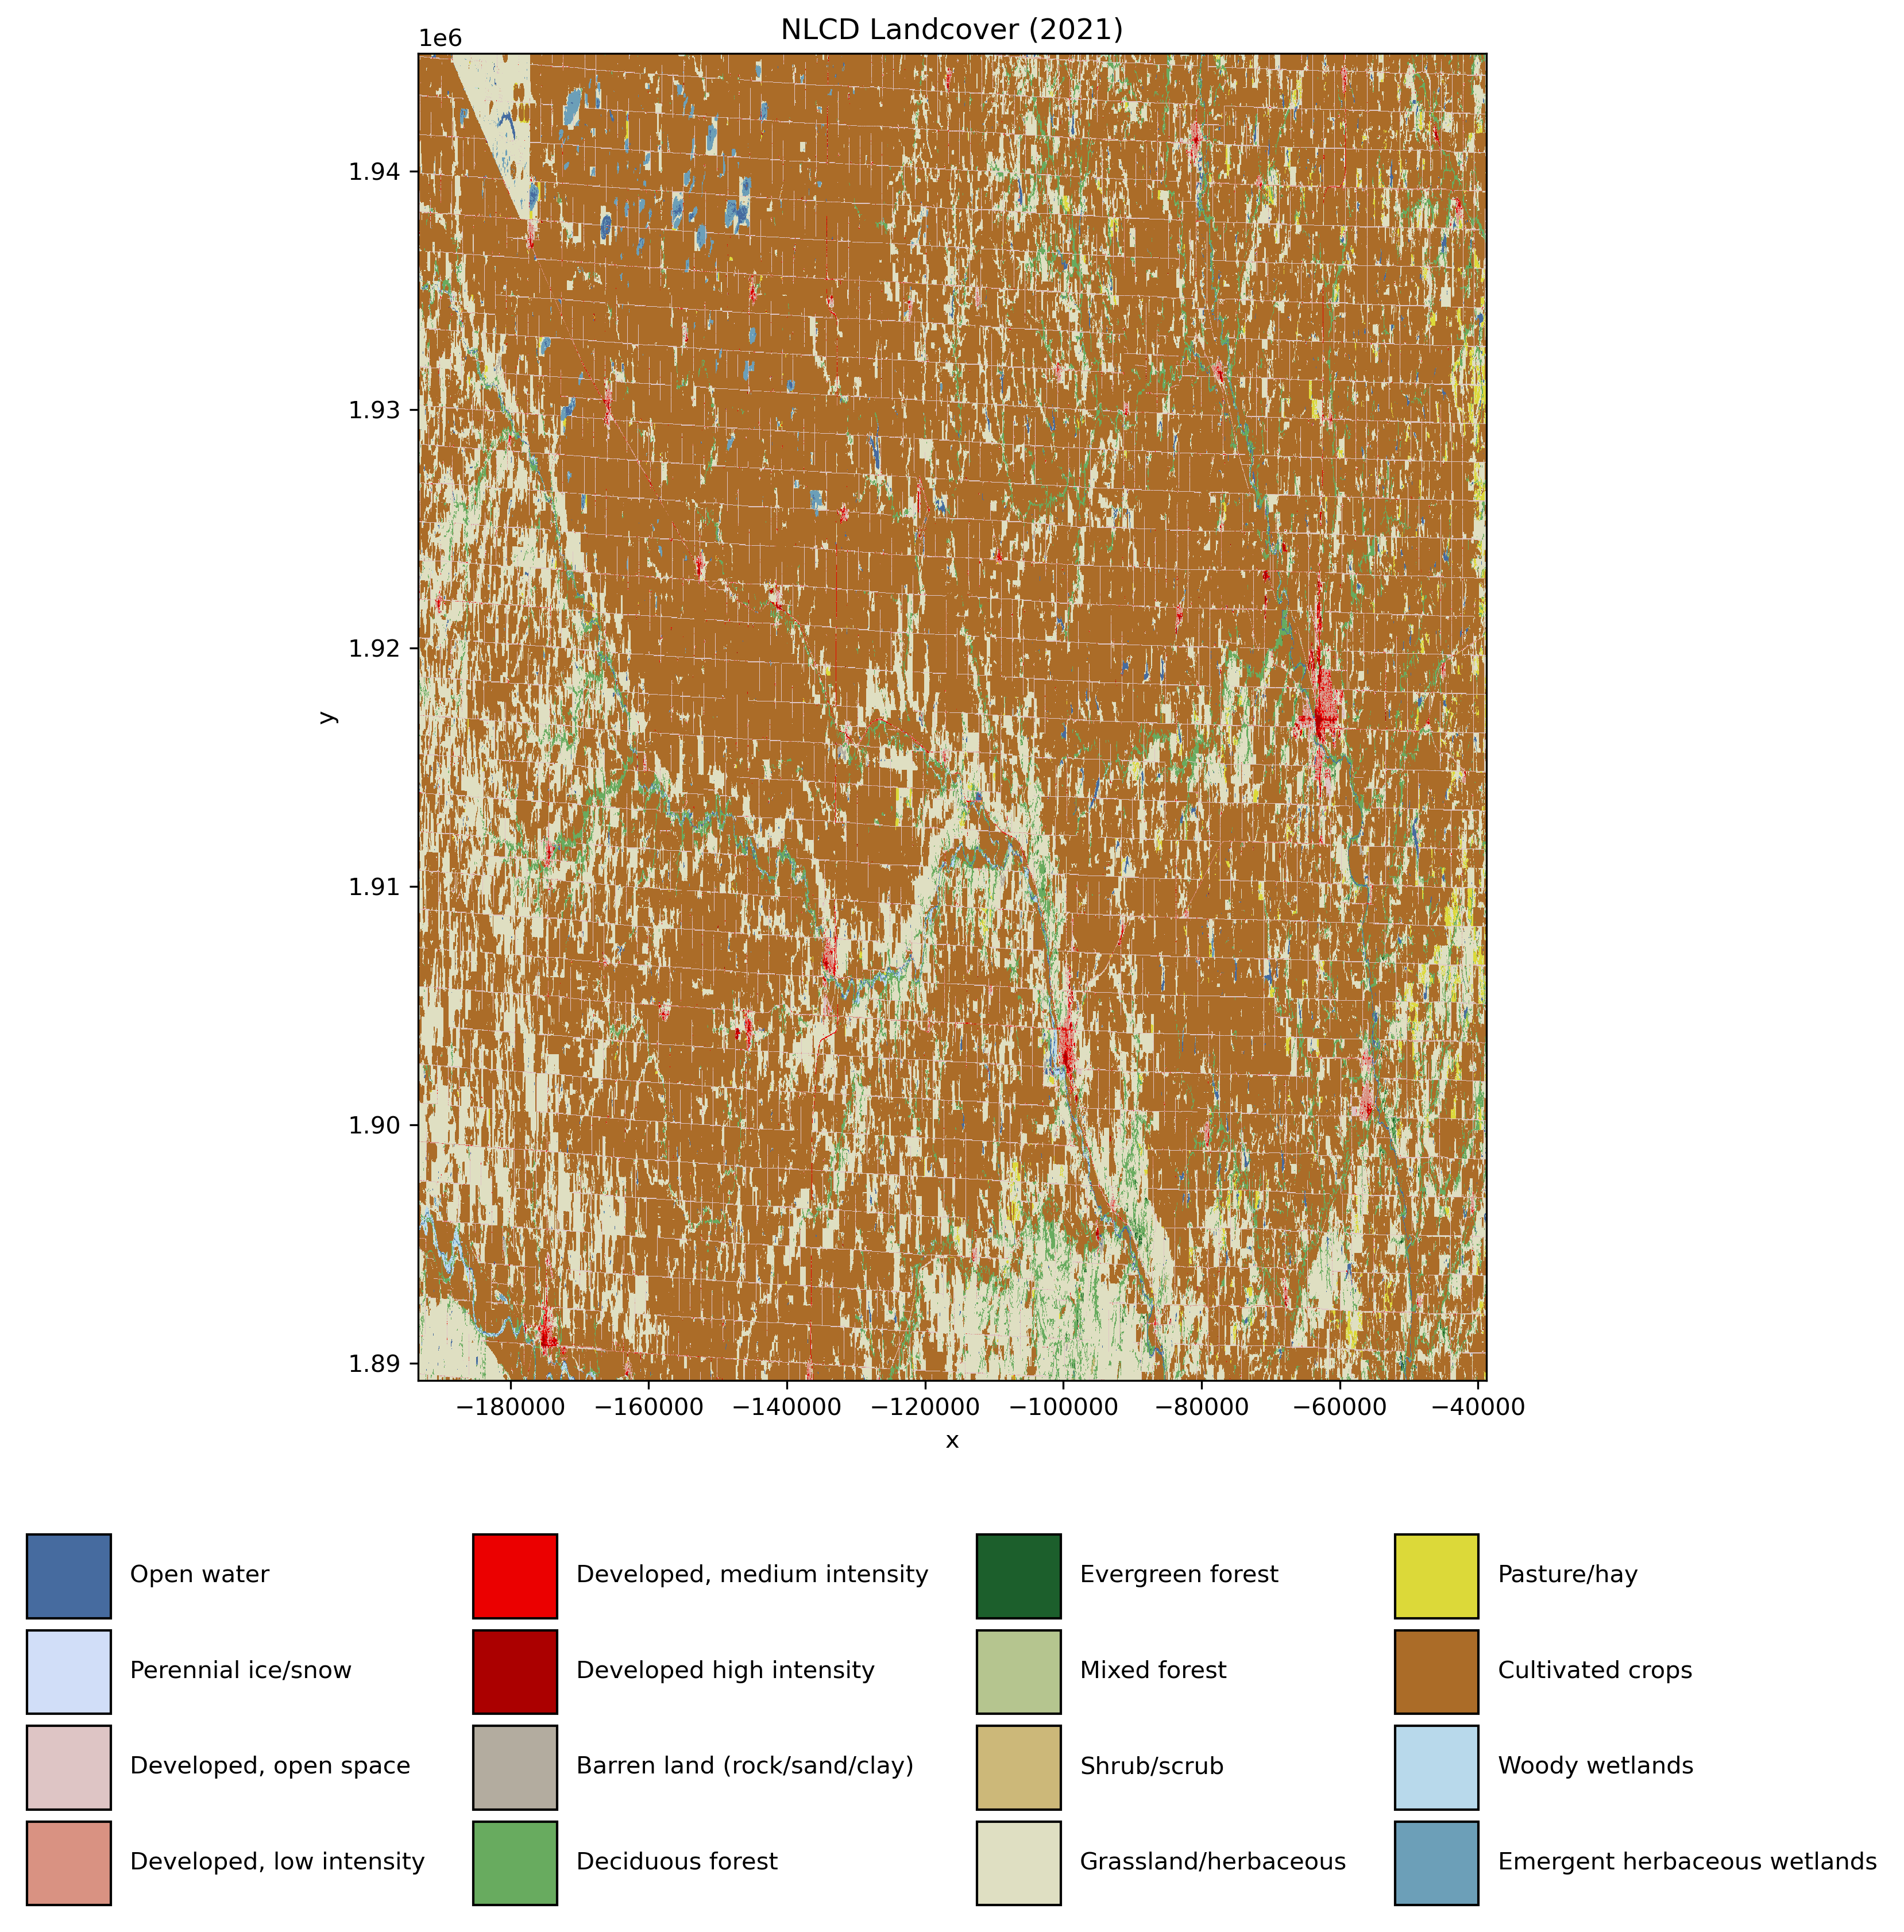

In [ ]:
nlcd_landcover_da.attrs['example_plot'](nlcd_landcover_da);

Now let's look at the distribution of our LULC over all of our sites

In [21]:
gf_sites_3857 = gf_sites_4326.to_crs(3857)
gf_conus_3857 = gf_conus.to_crs(3857)

 65%|██████▍   | 24/37 [01:40<00:35,  2.71s/it]/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
100%|██████████| 37/37 [02:37<00:00,  4.25s/it]
/tmp/ipykernel_558182/1604465969.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


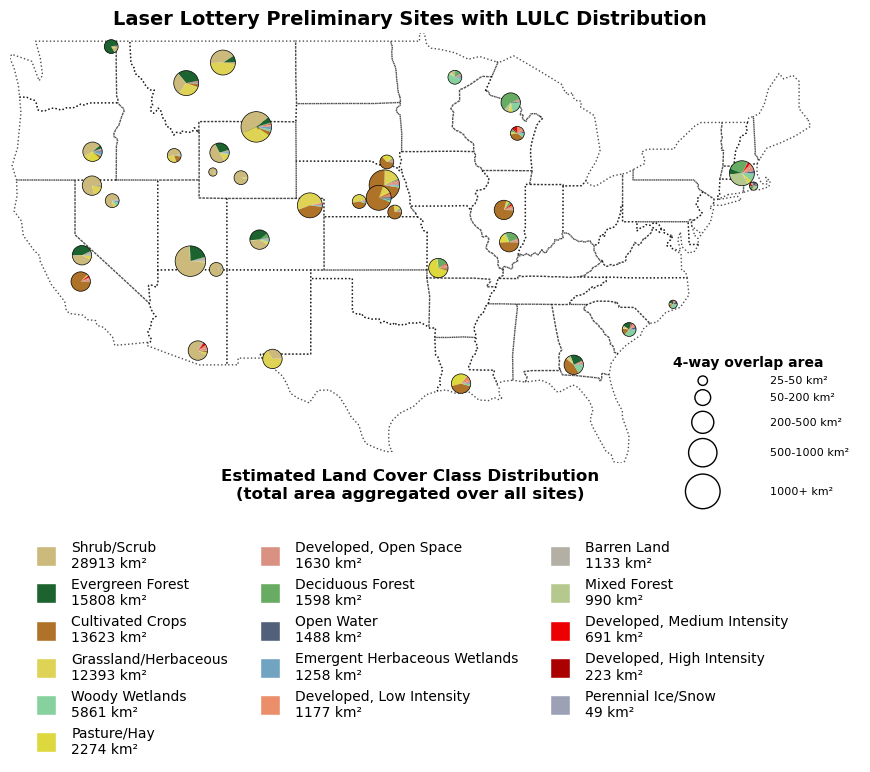

In [ ]:
# manually define NLCD land cover classes, labels, and colors for viz
nlcd_colors = {
    11: '#526079', 12: '#9CA1B6', 21: '#D99282', 22: '#EB8F6A', 23: '#ED0000',
    24: '#AA0000', 31: '#B3AFA4', 41: '#68AB63', 42: '#1C6330', 43: '#B5C98E',
    51: '#CCB879', 52: '#CCBA7C', 71: '#DFD355', 72: '#AA7028', 73: '#BAA065',
    74: '#D1BB80', 81: '#DDD83E', 82: '#AE7229', 90: '#87D19E', 95: '#71A4C1'
}
nlcd_labels = {
    11: "Open Water", 12: "Perennial Ice/Snow", 21: "Developed, Open Space", 22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity", 24: "Developed, High Intensity", 31: "Barren Land", 41: "Deciduous Forest",
    42: "Evergreen Forest", 43: "Mixed Forest", 51: "Dwarf Scrub", 52: "Shrub/Scrub", 71: "Grassland/Herbaceous",
    72: "Sedge/Herbaceous", 73: "Lichens", 74: "Moss", 81: "Pasture/Hay", 82: "Cultivated Crops", 90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands"
}

# dict to store the total area of each class
total_area = {key: 0 for key in nlcd_labels.keys()}
cell_area_km2 = 0.0009

# helper function to manually assign a circle radius based on the overlap area bins
# need to do this for accurate legend -> map symbology mapping
def get_radius(overlap_area):
    conversion_factor = 111320  # approximate meters per degree at the equator
    if 25 <= overlap_area < 50:
        return 0.3 * conversion_factor
    elif 50 <= overlap_area < 200:
        return 0.5 * conversion_factor
    elif 200 <= overlap_area < 500:
        return 0.7 * conversion_factor
    elif 500 <= overlap_area < 1000:
        return 0.9 * conversion_factor
    elif overlap_area >= 1000:
        return 1.1 * conversion_factor
    else:
        return 0.3 * conversion_factor

f, ax = plt.subplots(figsize=(9, 20))
gf_conus_3857.plot(ax=ax, facecolor="none", edgecolor="black", linestyle=":", alpha=0.7)
ax.set_aspect('equal')

# iterate over each site to create a pie chart and calculate area
for i, row in tqdm(gf_sites_3857.iterrows(), total=len(gf_sites_3857)):
    centroid = row.geometry.centroid
    nlcd_landcover = esd.remote_sensing.get_nlcd_landcover(gf_sites_4326.iloc[i].geometry, layer='landcover')
    
    if nlcd_landcover is not None:
        flattened = nlcd_landcover.values.flatten()
        flattened = flattened[~np.isnan(flattened)]
        
        # get the area per class for this site
        unique_values, counts = np.unique(flattened, return_counts=True)
        total_count = counts.sum()
        for value, count in zip(unique_values, counts):
            if value in nlcd_labels:
                class_area = count * cell_area_km2
                total_area[value] += class_area

        # get pie chart radius based on the overlap area for this site
        overlap_area = row.fourway_overlap_area_km2
        radius = get_radius(overlap_area)
        
        # plot land cover pie chart at the site centroid using the dynamic radius
        class_percentages = pd.DataFrame({
            'Class Value': unique_values,
            'Percentage': (counts / total_count) * 100,
            'Color': [nlcd_colors.get(val, 'gray') for val in unique_values],
            'Label': [nlcd_labels.get(val, 'Unknown') for val in unique_values]
        })
        plt.pie(
            class_percentages['Percentage'],
            colors=class_percentages['Color'],
            center=(centroid.x, centroid.y),
            radius=radius
        )
        # black circle outline for each pie chart
        circ = plt.Circle((centroid.x, centroid.y), radius, edgecolor='black', facecolor='none', linewidth=0.5)
        ax.add_artist(circ)

# sorted legend handles based on total area values
legend_handles = [
    mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=nlcd_colors[key], markersize=15,
                  label=f"{nlcd_labels[key]}\n{total_area[key]:.0f} km²")
    for key in sorted(nlcd_colors.keys(), 
                     key=lambda x: total_area.get(x, 0) if x in nlcd_labels and total_area.get(x, 0) > 0 else -1,
                     reverse=True)
    if key in nlcd_labels and total_area.get(key, 0) > 0
]
plt.legend(handles=legend_handles, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, frameon=False)


# separate axes for the circle size legend
legend_ax = f.add_axes([0.75, 0.25, 0.25, 0.3], frameon=False)
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_aspect('equal', adjustable='box')
legend_ax.set_xlim(0, 1)
legend_ax.set_ylim(0, 1)
legend_ax.text(0.5, 0.85, '4-way overlap area', 
               ha='center', va='bottom', transform=legend_ax.transAxes, 
               fontsize=10, fontweight='bold')
legend_radii = [0.3, 0.5, 0.7, 0.9, 1.1]
area_ranges = ["25-50 km²", "50-200 km²", "200-500 km²", "500-1000 km²", "1000+ km²"]

# Need to do some additional manual tweaking to map the circle
# size on the map -> legend circle size
scale_factor = 0.07
legend_y = 0.8
spacing = 0.075
for r, label in zip(legend_radii, area_ranges):
    # draw the circle with the scaled radius
    circle = plt.Circle((0.3, legend_y), r * scale_factor, fill=False, 
                        edgecolor='black', lw=1, transform=legend_ax.transAxes)
    legend_ax.add_patch(circle)
    # label to the right of the circle
    legend_ax.text(0.6, legend_y, label, va='center', transform=legend_ax.transAxes, fontsize=8)
    # more manual formatting
    if r == 0.5:
        spacing=0.11
    elif r == 0.7:
        spacing=0.135
    elif r == 0.9:
        spacing=0.172
    elif r == 1.1:
        spacing=0.195
    legend_y -= spacing


plt.text(0.5, -0.05, 
         'Estimated Land Cover Class Distribution\n(total area aggregated over all sites)', fontweight='bold', 
         ha='center', va='center', transform=ax.transAxes, fontsize=12)
#min_x, min_y, max_x, max_y = gf_conus.total_bounds
#ax.set_xlim(min_x, max_x)
#ax.set_ylim(min_y, max_y)
ax.set_title("Laser Lottery Preliminary Sites with LULC Distribution", 
             fontsize=14, fontweight='bold')
ax.set_axis_off()

plt.tight_layout();

### ICESat-2 ATL06

"SlideRule is a web service for on-demand science data processing, which provides researchers and other Earth science data systems low-latency access to customized data products using processing parameters supplied at the time of the request. SlideRule runs in AWS us-west-2 and has access to ICESat-2, GEDI, Landsat, ArcticDEM, REMA, and other datasets stored in S3" https://slideruleearth.io/web/rtd/

ICESat-2 (Ice, Cloud, and land Elevation Satellite-2) is a NASA mission launched in 2018 to measure changes in Earth's ice sheets, forests, and land surfaces with an advanced photon-counting laser altimeter known as ATLAS (Advanced Topographic Laser Altimeter System). The satellite fires laser pulses at a rate of **10,000 pulses per second**, with each pulse containing approximately **20 trillion photons**. However, only about a dozen photons per pulse are typically returned to the sensor after reflecting off Earth's surface.

Each laser pulse covers a **footprint of ~11 meters in diameter**, and ICESat-2 operates in a unique **six-beam configuration**: three pairs of strong and weak beams, allowing for enhanced accuracy in terrain and vegetation height measurements. The beams are spaced approximately **3.3 km apart** on the ground, enabling differentiation between slopes and terrain features.

ICESat-2's data processing is divided into different levels:
- **ATL03**: Provides geolocated individual photon returns.
- **ATL06**: Generates refined surface heights by filtering and averaging photons from ATL03.
- **ATL08**: Extracts land and vegetation canopy height.

NASA’s standard algorithms correct for atmospheric interference, geolocation errors, and classify photons based on confidence levels (e.g., high-confidence signal vs. background noise). These corrections ensure highly precise elevation measurements, with surface elevation accuracy reaching within **10 cm under ideal conditions**. That being said, performance struggles over areas of dense vegetation and complex terrain, where signal photons are often obscured or misclassified due to canopy penetration, multiple scattering, and terrain-induced geolocation errors. As a result, standard ATL06 processing may underestimate true ground elevation or fail to accurately distinguish between canopy and surface returns. Custom ATL06 processing algorithms aim to refine photon selection criteria, leverage ancillary datasets, and optimize spatial filtering techniques to improve elevation estimates in these challenging environments.

#### Key ATL03 Processing Parameters
Below is a table highlighting some of the most important ATL03 parameters that influence ATL06 processing:

| **Parameter**    | **Description** |
|-----------------|----------------|
| **srt**         | Surface type classification, indicating the type of terrain or surface (e.g., land, ocean, sea ice). |
| **cnf**         | Confidence level of photon events, ranging from -2 (low confidence, possibly background) to 4 (high confidence, likely signal). |
| **ats**         | Along-track distance in meters, specifying the length of the segment over which data is processed. |
| **cnt**         | Number of segments to process, defining how many consecutive segments are included in the analysis. |
| **len**         | Length of each segment in meters, determining the size of the data chunks for processing. |
| **res**         | Resolution of the output data in meters, specifying the spatial granularity of the results. |
| **n_fit_photons** | Number of photons used in the surface height estimate for the segment. |
| **atl08_class** | Classification flag from ATL08, denoting surface type such as land, canopy, or snow/ice. |

For more information, visit NASA’s [ICESat-2 website](https://icesat-2.gsfc.nasa.gov/) or the [SlideRule documentation](https://slideruleearth.io/web/rtd/).

In [23]:
# TODO: grab a single USGS 3DEP tile and use the coincident main panel figure to show differences

In [17]:
sliderule.init("slideruleearth.io", verbose=False)
earthdata.set_max_resources(max_resources=1000)
icesat2.init("slideruleearth.io")

In [18]:
# we'll pull in data for one of our sites as an example before we expand in a later notebook
poly_sliderule = sliderule.toregion(gf_search)['poly']
geojson = earthdata.tnm(short_name='Digital Elevation Model (DEM) 1 meter', 
                        polygon=poly_sliderule)

In [ ]:
# https://nbviewer.org/github/ICESat2-SlideRule/sliderule-python/blob/main/examples/phoreal.ipynb
parms = {
    "poly": poly_sliderule,
    "t0": "2019-01-01T00:00:00Z", # first 3 months of 2019 arbitrarily to save time
    "t1": "2019-03-31T23:59:59Z",
    "samples": {"3dep": {"asset": "usgs3dep-1meter-dem", "catalog": geojson}} 
}

In [ ]:
# TODO: huh?? why doesn't ATL06p return anything and why does this take so long (56 seconds)
# probably 3dep sampling
%time
atl06 = icesat2.atl06sp(parms)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.68 μs


In [35]:
print(f"CRS: {atl06.crs}, Shape: {atl06.shape}")
atl06.head(2)

CRS: EPSG:7912, Shape: (82793, 25)


,h_li,h_li_sigma,r_eff,sigma_geo_h,segment_id,cycle,h_robust_sprd,bsnow_conf,dh_fit_dx,x_atc,...,gt,atl06_quality_summary,bsnow_h,seg_azimuth,tide_ocean,geometry,3dep.file_id,3dep.time,3dep.value,3dep.flags
time,,,,,,,,,,,,,,,,,,,,,
2019-01-18 17:20:03.144040448,NaN,NaN,NaN,NaN,221952,2,4.890703,-4,-0.991994,4.451033e+06,...,50,1,NaN,-5.482420,NaN,POINT (-97.03626 40.00244),NaN,NaN,NaN,NaN
2019-01-18 17:20:03.482733056,81.471153,0.306084,0.02531,5.001851,222071,2,1.185331,-4,-0.007151,4.453418e+06,...,50,1,NaN,-5.482338,NaN,POINT (-97.03877 40.02384),"[51539607556, 51539607557]","[1337032878.0, 1309212315.0]","[nan, 376.79339171824836]","[0, 0]"


In [36]:
# TODO: no h_mean??
atl06.columns

Index(['h_li', 'h_li_sigma', 'r_eff', 'sigma_geo_h', 'segment_id', 'cycle',
       'h_robust_sprd', 'bsnow_conf', 'dh_fit_dx', 'x_atc', 'y_atc', 'rgt',
       'n_fit_photons', 'w_surface_window_final', 'spot', 'gt',
       'atl06_quality_summary', 'bsnow_h', 'seg_azimuth', 'tide_ocean',
       'geometry', '3dep.file_id', '3dep.time', '3dep.value', '3dep.flags'],
      dtype='object')

https://github.com/SlideRuleEarth/sliderule-python/blob/main/examples/3dep_gedi_sample.ipynb

https://github.com/ICESAT-2HackWeek/surfit/blob/main/contributors/ben/DEM_Comparison_02_plot.ipynb

<Figure size 600x300 with 0 Axes>

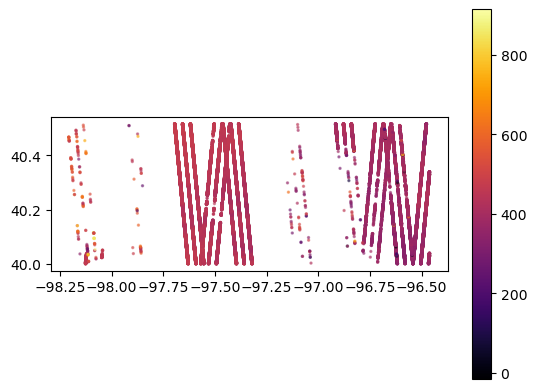

In [41]:
# TODO: hillshade
plt.figure(figsize=(6,3))
atl06.plot(column="h_li", alpha=0.5, cmap="inferno", s=2,
           legend=True);

In [60]:
def get_elevation(x):
    if isinstance(x, float) or x is None:  # Handle NaN and None values
        return np.nan
    if len(x) > 1:  # Only access index 1 if the list/array has at least 2 elements
        return x[1]
    return np.nan
atl06['3dep_elev'] = atl06['3dep.value'].apply(get_elevation)
atl06['elev_diff'] = atl06['h_li'] - atl06['3dep_elev']

In [ ]:
#TODO: showcase outliers

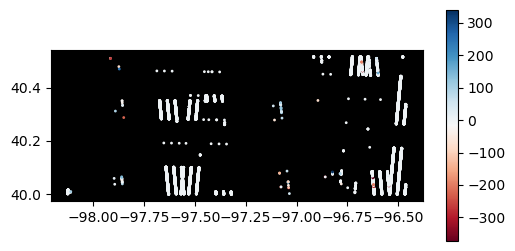

In [63]:
# TODO: hillshade
f, ax = plt.subplots(figsize=(6,3))
ax.set_facecolor("black")
atl06.plot(column="elev_diff", alpha=1, cmap="RdBu", s=1,
           legend=True, ax=ax);